# EDA...

In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
os.listdir("./dataset")

['batches.meta',
 'data_batch_1',
 'data_batch_2',
 'data_batch_3',
 'data_batch_4',
 'data_batch_5',
 'readme.html',
 'test_batch']

In [4]:
train_batches = ['data_batch_1',
 'data_batch_2',
 'data_batch_3',
 'data_batch_4',
 'data_batch_5',]

test_batch = 'test_batch'

In [5]:
random_data = unpickle("./dataset/data_batch_1")
print(random_data.keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [6]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_class_map = {i: classes[i] for i in range(10)}

In [7]:
def load_batch(file):
    data = unpickle(file)
    X = data[b'data']
    Y = data[b'labels']
    names = data[b'filenames']
    return X, Y, names

In [8]:
## Create a function that can display the image
def display_image(image):
    image = image.reshape(3, 32, 32).transpose([1, 2, 0])
    plt.imshow(image)
    plt.show()

In [9]:
## Create one dataset from all the batches and see class distributions:

images, labels = [], []

for batch in train_batches:
    X, Y, _ = load_batch(f"./dataset/{batch}")
    images.extend(X)
    labels.extend(Y)

images = np.array(images)
labels = np.array(labels)

print(images.shape)

(50000, 3072)


<BarContainer object of 10 artists>

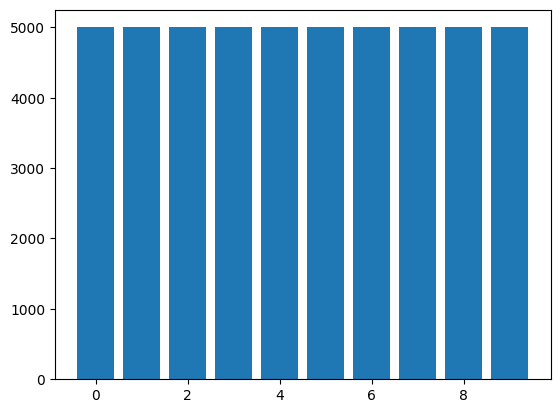

In [10]:
## See Class Distributions
from collections import Counter
class_distribution = Counter(labels)

plt.bar(class_distribution.keys(), class_distribution.values()) ## Sexy! 5000 images per class -> 10 classes -> 50000 images

<Figure size 1000x1000 with 0 Axes>

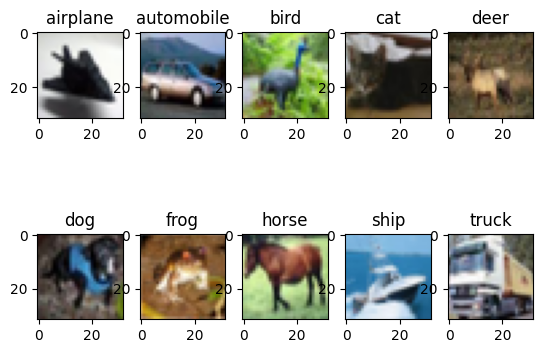

In [11]:
## Displaying random image from each class in subplots 5 * 2, each subplot is a class with title from class_label_map
unique_labels = np.unique(labels)

plt.figure(figsize=(10, 10))
fig, ax = plt.subplots(2, 5)

for label in unique_labels:
    image_index = np.where(labels == label)[0][0]
    image = images[image_index]
    image = image.reshape(3, 32, 32).transpose([1, 2, 0]) ## 1, 2, 0 means 0th axis is 1, 1st axis is 2, 2nd axis is 0 (Originally what we have is 0, 1, 2)
    ax[label // 5, label % 5].imshow(image)
    ax[label // 5, label % 5].set_title(label_class_map[label])

plt.show()

(50000, 3, 32, 32)

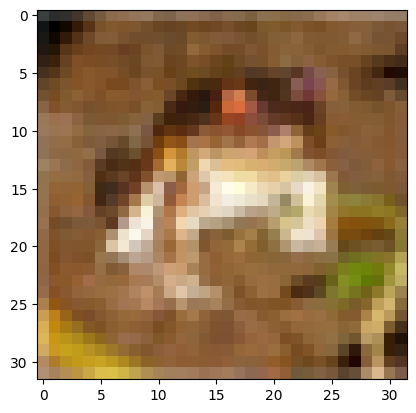

In [12]:
## Reshape the images to 3 * 32 * 32
images = images.reshape(-1, 3, 32, 32)
images = images / 255.0 ## Normalize the images
# images = images.transpose([0, 2, 3, 1]) ## Convert to N * H * W * C --> number of images * height * width * channels

plt.imshow(images[0].transpose([1, 2, 0]))
images.shape


In [13]:
## One hot encode the labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder()
labels = one_hot_encoder.fit_transform(labels.reshape(-1, 1)).toarray()

labels.shape

(50000, 10)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [15]:
## Define Model
# BATCH_SIZE = 32
# EPOCHS = 10
# NUM_CLASSES = 10


class model(nn.Module):
    def __init__(self, NUM_CLASSES=10):
        super().__init__()
        
        self.num_classes = NUM_CLASSES

        # Input shape: [batch_size, 3, 32, 32]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # Output: [batch_size, 32, 32, 32]
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)           # Output: [batch_size, 32, 30, 30]
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)                               # Output: [batch_size, 32, 15, 15]
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # Output: [batch_size, 64, 15, 15]
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)           # Output: [batch_size, 64, 13, 13]
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)                               # Output: [batch_size, 64, 6, 6]
        self.dropout2 = nn.Dropout(0.25)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 6 * 6, 512)  # Input: [batch_size, 64 * 6 * 6] -> Output: [batch_size, 512]
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, self.num_classes) # Output: [batch_size, num_classes]
    
    def forward(self, x):

        x = F.relu(self.conv1(x))  # After conv1: [batch_size, 32, 32, 32]
        x = F.relu(self.conv2(x))  # After conv2: [batch_size, 32, 30, 30]
        x = self.pool1(x)          # After pool1: [batch_size, 32, 15, 15]
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))  # After conv3: [batch_size, 64, 15, 15]
        x = F.relu(self.conv4(x))  # After conv4: [batch_size, 64, 13, 13]
        x = self.pool2(x)          # After pool2: [batch_size, 64, 6, 6]
        x = self.dropout2(x)

        x = self.flatten(x)        # After flatten: [batch_size, 64 * 6 * 6]
        x = F.relu(self.fc1(x))    # After fc1: [batch_size, 512]
        x = self.dropout3(x)
        x = self.fc2(x)            # After fc2: [batch_size, num_classes]
        
        return F.softmax(x, dim=1) # Applying softmax to output --> [batch_size, num_classes]

In [16]:
def poormans_data_loader(images, labels, batch_size=32):
    for i in range(0, len(images), batch_size):
        yield torch.tensor(images[i:i+batch_size], dtype=torch.float32), torch.tensor(labels[i:i+batch_size], dtype=torch.float32)

In [17]:
BATCH_SIZE = 1024
EPOCHS = 500 ## 200 1e-3, 200 1e-4, 100 1e-5
NUM_CLASSES = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classifier = model(NUM_CLASSES=NUM_CLASSES)
classifier.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-3) 

In [ ]:
## Training Loop

losses = []

for epoch in range(EPOCHS):
    for images_batch, labels_batch in poormans_data_loader(images, labels, BATCH_SIZE):
        optimizer.zero_grad()
        output = classifier(images_batch)
        loss = criterion(output, torch.argmax(labels_batch, dim=1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch: {epoch}, Loss: {loss}")

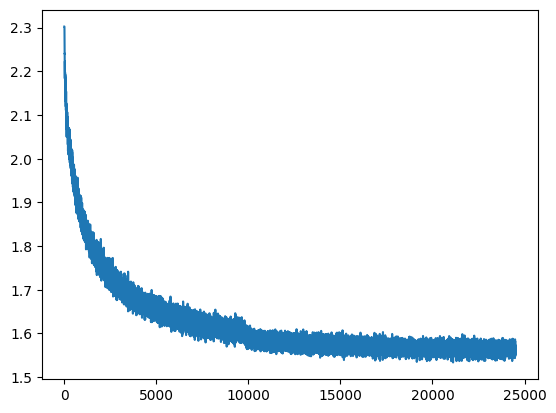

In [34]:
plt.plot(losses)

In [31]:
## Update lr to 1e-4
optimizer = optim.Adam(classifier.parameters(), lr=1e-5)

In [20]:
from sklearn.metrics import classification_report

In [35]:
test_images, test_labels, _ = load_batch(f"./dataset/{test_batch}")
test_images = test_images.reshape(-1, 3, 32, 32)
test_images = test_images / 255.0
test_labels = one_hot_encoder.transform(np.array(test_labels).reshape(-1, 1)).toarray()

test_images = torch.tensor(test_images, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)

test_images = test_images.to(DEVICE)
test_labels = test_labels.to(DEVICE)

with torch.no_grad():
    output = classifier(test_images)
    loss = criterion(output, torch.argmax(test_labels, dim=1))
    print(f"Test Loss: {loss}")

y_pred = torch.argmax(output, dim=1)
y_true = torch.argmax(test_labels, dim=1)

print(classification_report(y_true.cpu().numpy(), y_pred.cpu().numpy()))

Test Loss: 1.7418445348739624
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      1000
           1       0.85      0.84      0.84      1000
           2       0.62      0.59      0.61      1000
           3       0.52      0.52      0.52      1000
           4       0.66      0.65      0.65      1000
           5       0.63      0.64      0.64      1000
           6       0.77      0.78      0.77      1000
           7       0.76      0.74      0.75      1000
           8       0.81      0.81      0.81      1000
           9       0.82      0.82      0.82      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



In [47]:
## Save the model
torch.save(classifier.state_dict(), "cifar10_model.pth")

In [48]:
## Loadnig the model

# classifier = model(NUM_CLASSES=NUM_CLASSES)
# classifier.load_state_dict(torch.load("cifar10_model.pth"))